In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (16, 9)

# Assignment 2

## 1. Image Stitching 

This problem will walk you through the process of image stitching by detecting and matching corners, and estimating the homography based the matches.

### 1a. Detect Keypoints and Calculate Descriptors (10 points)

Load the sample image pair.

In [2]:
img1 = cv2.imread('data/graff1.png')
img2 = cv2.imread('data/graff2.png')

Since we have implemented the Harris corner detector from scratch in the weekly notebooks, in this problem we will use OpenCV to detect corners and get their descriptors. In the cell below, detect feature points and calculate their descriptors in both images using OpenCV's ORB detector and descriptor.

In [3]:
orb = cv2.ORB_create()
kp1 = orb.detect(img1, None)
kp2 = orb.detect(img2, None)

kps1, des1 = orb.compute(img1, kp1)
kps2, des2 = orb.compute(img2, kp2)

Visualize locations of detected features.

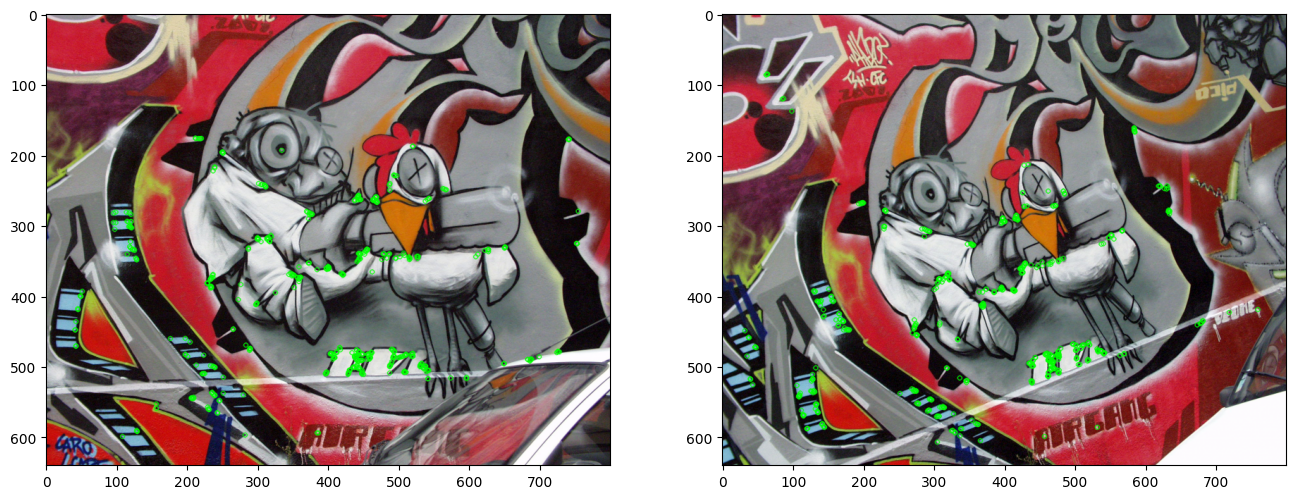

In [4]:
kp_img1 = cv2.drawKeypoints(img1, kps1, None, color=(0,255,0))
kp_img2 = cv2.drawKeypoints(img2, kps2, None, color=(0,255,0))

fig, axs = plt.subplots(1, 2)
axs[0].imshow(cv2.cvtColor(kp_img1, cv2.COLOR_BGR2RGB))
axs[1].imshow(cv2.cvtColor(kp_img2, cv2.COLOR_BGR2RGB))
plt.show()

### 1b. Match Keypoints (10 points)

Check out OpenCV's online docs and answer the following question:
- What attributes does each detected keypoint have? Briefly explain what they represent.

In [5]:
# Type your answer below:

# point: the x and y coordinates of the keypoint
# size: the keypoint diameter
# angle: the orientation of the keypoint
# response: the detector response, the strength of the keypoint
# octave: gives octave in which the keypoint has been detected

- What is the "apparent" size of each descriptor and what data type does it have? (You can easily find the answer by printing the `shape` and `dtype` of a descriptor.) The ORB [paper](https://ieeexplore.ieee.org/document/6126544) says "*we propose a very fast **binary** descriptor based on BRIEF, called ORB*." Based on this, what is the actual length of each binary descriptor?

In [5]:
# Type your answer below:
print("Descriptor shape: ", des1.shape)
print("Descriptor data type: ", des1.dtype)

Descriptor shape:  (500, 32)
Descriptor data type:  uint8


- Given two ORB descriptors, how should you measure their distance?

In [7]:
# Type your answer below:

# For binary descriptors, like ORB, the Hamming distance is used.

Using `cv2.BFMatcher`, calculate the matching between the two lists of keypoints. Be sure to use the correct distance measurement. Also, set `crossCheck=True` when creating the matcher. After you get the matches, sort them by distance and call `cv2.drawMatches()` to display the 100 closest matches.

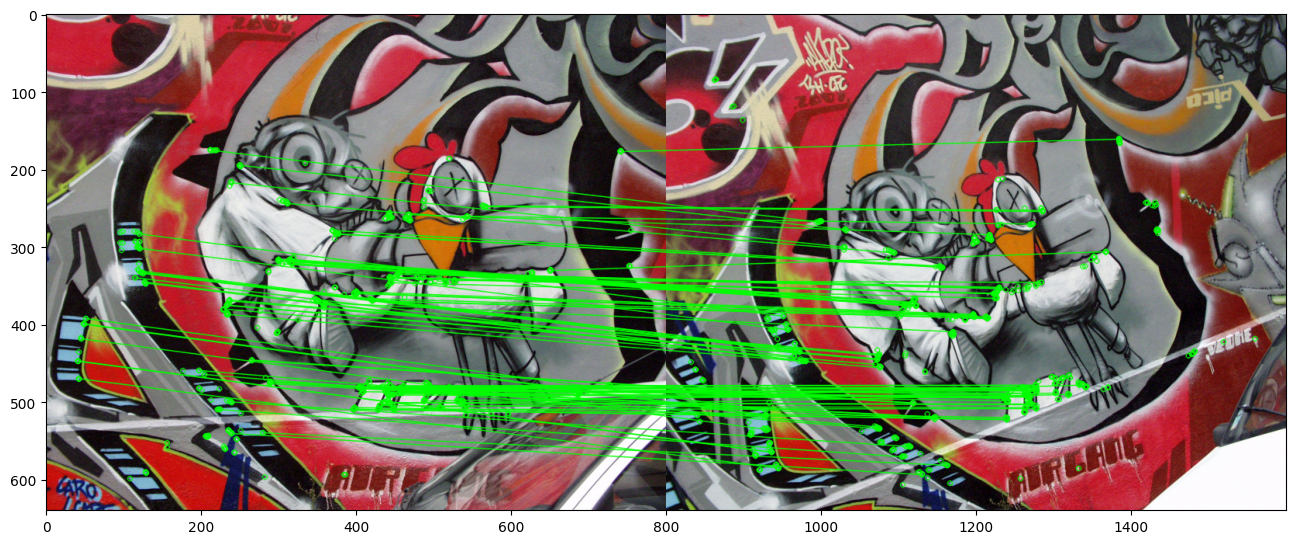

In [6]:
BruteForce = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = BruteForce.match(des1, des2)
# Sort matches to get best 100
matches = sorted(matches, key=lambda x: x.distance)
match_img = cv2.drawMatches(img1, kps1, img2, kps2, matches[:100], None, matchColor=(0,255,0), singlePointColor=(0,255,0))
plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
plt.show()

### 1c. Calculate Homography Between Matching Keypoints (20 points)

Implement the following function to calculate the projective transformation that maps a list of (x, y) coordinates `pts1` to the list of matching coordinates `pts2`. The return value is a 3x3 array representing the transformation matrix. You don't need to worry about there being outlier matches between `pts1` and `pts2` here.

You should implement this from from scratch and may **NOT** simply call functions from OpenCV or other libraries to solve this for you. 

In [103]:
def get_homography(pts1, pts2):
    """Estimate the affine transformation between two lists of matching
    keypoint coordinates.
    
    Args:
    - pts1: List of (x, y) coordinates.
    - pts2: List of (x, y) coordinates.
    
    Returns:
    - t: 3x3 array representing the projective transformation matrix that
          maps `pts1` to `pts2`.
    """
    assert len(pts1) == len(pts2), \
        "`pts1` and `pts2` must have equal length."
    # TODO
    A = []
    # Go through list of points
    for i in range(len(pts1)):
        x1, y1 = pts1[i]
        x2, y2 = pts2[i]
        # Create A matrix
        A.append([x1, y1, 1, 0, 0, 0, -x2*x1, -x2*y1, -x2])
        A.append([0, 0, 0, x1, y2, 1, -y2*x1, -y2*y1, -y2])

    A = np.array(A)
    # Get singular value decomposition
    U, S, V = np.linalg.svd(A)
    # Select first column and reshape to a 3x3 matrix
    t = V[-1].reshape(3, 3)

    # Error seems pretty big...
    # homogeneous_pts1 = np.array(pts1[0] + [1])
    # homogeneous_pts2 = np.array(pts2[0] + [1])
    # print(np.dot(t, homogeneous_pts1.T)-homogeneous_pts2)
    H, status = cv2.findHomography(np.array(pts1), np.array(pts2))
    # print(np.dot(H, homogeneous_pts1)-homogeneous_pts2)
    # print(t)
    # print(H)
    # print(t-H)
    return H


# Test the function on sample keypoints.
pts1 = [
    [313.9, 316.8],
    [120.0, 284.0],
    [437.2, 501.1],
    [221.0, 510.0],
]
pts2 = [
    [318.0, 372.0],
    [151.0, 390.0],
    [466.6, 504.0],
    [304.0, 571.0],
]
t = get_homography(pts1, pts2)
print(t)

[[ 8.90377563e-01  3.14823753e-01 -4.23004182e+01]
 [-1.76642996e-01  9.37755197e-01  1.52506377e+02]
 [ 2.09313153e-04 -1.95391992e-05  1.00000000e+00]]


### 1d. Estimate Affine Transformation Between Images Using RANSAC (30 points)

Implement the following function to estimate the homography between two images given keypoints and matches. There may be outliers in the keypoint matches and you should implement the RANSAC algorithm to reject them. You should implement RANSAC from scratch and may **NOT** simply call the corresponding functions in OpenCV or any other existing libraries.

In [133]:
import random


def estimate_transformation_ransac(kps1, kps2, matches, transform_func,
    n_samples, n_trials, inlier_thresh):
    """Estimate the transformation between two matching lists of keypoints 
    using RANSAC.
    
    Args:
    - kps1: A list of `cv2.KeyPoint` objects.
    - kps2: A list of `cv2.KeyPoint` objects.
    - matches: A list of `cv2.DMatch` objects representing the matches
          between `kps1` and `kps2`.
    - transform_func: Function used to estimate the transformation given
          matching points.
    - n_samples: The number of samples in each RANSAC trial.
    - n_trials: The total number of RANSAC trials.
    - inlier_thresh: The threshold used to determine whether a match is an
          inlier or not.
    
    Returns:
    - transform: The 3x3 transformation matrix that maps kps1 to kps2.
    - mask: A list of Boolean values representing whether the corresponding
          match is an inlier or not.
    """
    # TODO
    best_transform = None
    best_inlier_count = 0

    for _ in range(n_trials):
        # Randomly select 'n_samples' matches
        random_matches = np.random.choice(matches, n_samples, replace=False)

        

        inlier_count = 0
        inlier_mask = []

        #Go through every match and check if the keypoint transform is inlier or not
        for match in random_matches:
            
            # Get keypoint vector from match (had to google this)
            RANSAC_kp1 = kps1[match.queryIdx].pt
            RANSAC_kp2 = kps2[match.trainIdx].pt

            # Transform first keypoint and normalize to check difference with second keypoint
            transformed_RANSAC_kp1 = np.dot(transform, np.array([RANSAC_kp1[0], RANSAC_kp1[1], 1]))
            transformed_RANSAC_kp1 /= transformed_RANSAC_kp1[2]

            # Calculate the difference beteen the 2
            difference = np.linalg.norm(np.array([RANSAC_kp2[0], RANSAC_kp2[1]]) - transformed_RANSAC_kp1[:2])

            # If difference is within threshold, match is an inlier, append mask accordingly
            if difference < inlier_thresh:
                inlier_count += 1
                inlier_mask.append(True)
            else:
                inlier_mask.append(False)
        
        # Check if these random samples give more inliers than the previous one to find the best transform
        if inlier_count > best_inlier_count:
            best_inlier_count = inlier_count
            best_transform = transform

    return best_transform, inlier_mask

transform, mask = estimate_transformation_ransac(kps1, kps2, matches, get_homography, 10, 100, 0.2)
print(f"The transformation matrix:\n{transform}.")
print(f"{np.sum(mask)} out of {len(matches)} matches are inliers.")

The transformation matrix:
[[ 8.94489419e-01  3.12484716e-01 -4.09553896e+01]
 [-1.71399027e-01  9.43597804e-01  1.49131333e+02]
 [ 2.23157785e-04 -2.46788003e-05  1.00000000e+00]].
1 out of 280 matches are inliers.


The following cell warps image 1 based on the estimated homography and displays the overlay of the aligned images.

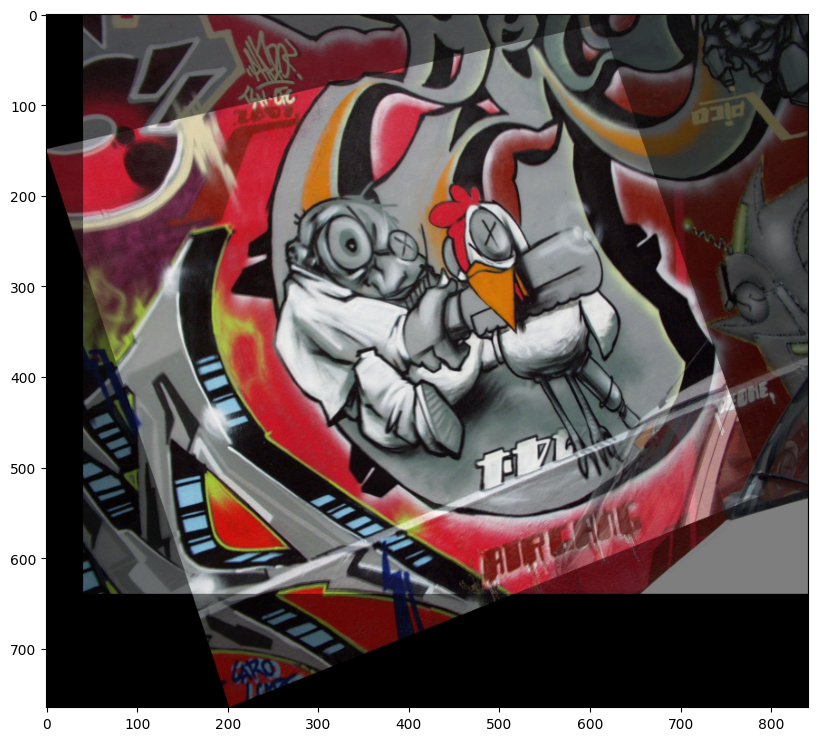

In [134]:
def stitch_images(img1, img2, transform):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # Warp corners of image 1 to coordinates system of image 2.
    corners = np.array([
        [0., w1, w1, 0.],
        [0., 0., h1, h1],
        [1., 1., 1., 1.]
    ])
    new_corners = transform @ corners
    new_corners /= new_corners[2, :]
    # Calculate range of warped image 1.
    l = np.min(new_corners[0, :])
    r = np.max(new_corners[0, :])
    t = np.min(new_corners[1, :])
    b = np.max(new_corners[1, :])
    # Calculate size of the stitched image.
    l = np.min((l,  0))
    r = np.max((r, w2))
    t = np.min((t,  0))
    b = np.max((b, h2))
    w = int(np.round(r-l))
    h = int(np.round(b-t))
    # Calculate how much we should shift the stitched image.
    dx = max((-l, 0.))
    dy = max((-h, 0.))
    shift = np.array([
        [1., 0., dx],
        [0., 1., dy],
        [0., 0., 1.]
    ])

    # Warp input images and overlay them.
    warped_img1 = cv2.warpPerspective(img1, shift @ transform, (w, h))
    warped_img2 = cv2.warpPerspective(img2, shift, (w, h))
    overlayed_img = cv2.addWeighted(warped_img1, 0.5, warped_img2, 0.5, 0.0)
    return overlayed_img


stitched_img = stitch_images(img1, img2, transform)
plt.imshow(cv2.cvtColor(stitched_img, cv2.COLOR_BGR2RGB))
plt.show()

# 2. Disparity Map (30 points)

In this problem you will find dense correspondences between the stereo image pair below and calculate the disparity map. This will be done by doing template matching between image windows.

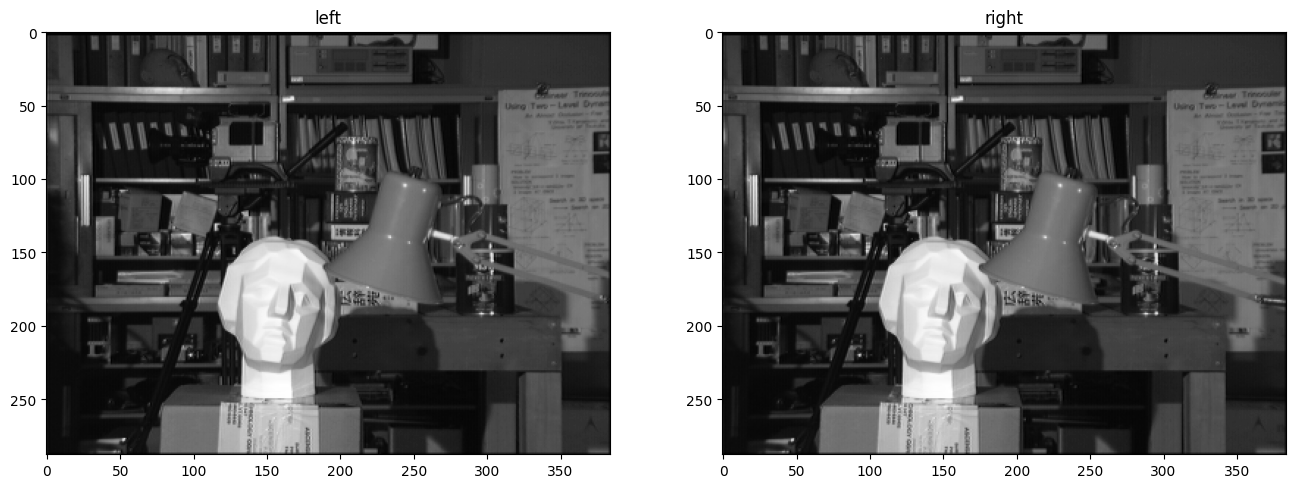

In [136]:
img1 = cv2.imread('data/left.bmp')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGRA2GRAY) / 255.

img2 = cv2.imread('data/right.bmp')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGRA2GRAY) / 255.

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img1, cmap='gray')
ax1.set_title('left')
ax2.imshow(img2, cmap='gray')
ax2.set_title('right')
plt.show()

In the cell below, implement a system to calculate the disparity map and visualize the results. You can assume that the camera angle of the images are already rectified, so the epipolar lines are all horizontal. Use SSD as the similarity measure between windows. Set the window size to `7` and the maximum disparity value to `40`.

A naive implementation could take several minutes to run and you should avoid that. Recall from the lectures that we covered a more efficient implementation.

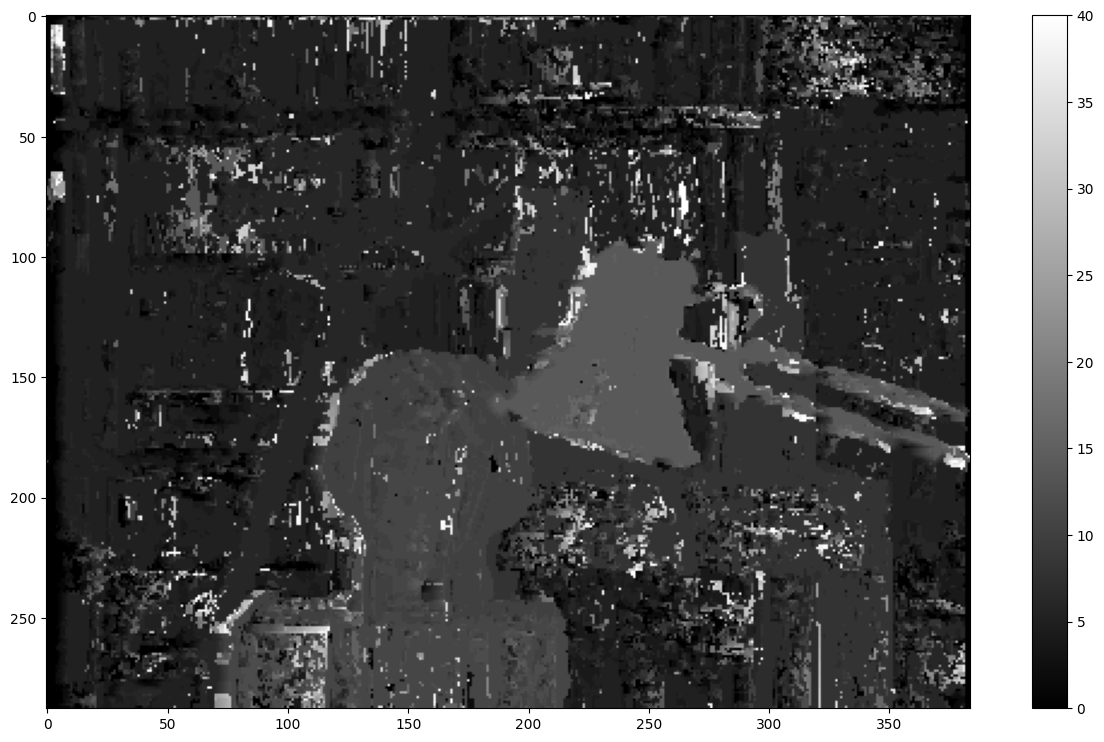

In [138]:
from scipy.signal import convolve2d


assert img1.shape == img2.shape
h, w = img1.shape

dmin, dmax = 0, 40  # disparity search range
s = 7  # windows size
'''
# TODO
# Initialize the disparity map with zeros
disp = np.zeros((h, w), dtype=np.float32)

# Iterate through the left image
for y in range(s // 2, h - s // 2):
    for x in range(s // 2, w - s // 2):
        # Define the template window in the left image
        template = img1[y - s // 2:y + s // 2 + 1, x - s // 2:x + s // 2 + 1]

        # Initialize variables to track the best disparity and the minimum SSD
        best_disparity = dmin
        min_ssd = float('inf')

        # Iterate through the disparity range
        for d in range(dmin, dmax + 1):
            # Define the corresponding window in the right image
            x_right = x - d
            if x_right < s // 2:
                continue
            window_right = img2[y - s // 2:y + s // 2 + 1, x_right - s // 2:x_right + s // 2 + 1]

            # Calculate the sum of squared differences (SSD)
            ssd = np.sum((template - window_right) ** 2)

            # Update the best disparity if the SSD is smaller
            if ssd < min_ssd:
                min_ssd = ssd
                best_disparity = d

        # Store the best disparity in the disparity map
        disp[y, x] = best_disparity
'''
# Get the size of the images
rows, columns = img1.shape

# Arrays for best disparities
best = np.inf * np.ones((rows, columns))
disp = np.zeros((rows, columns), dtype=int)

# Loop through disparities
for k in range(dmin, dmax + 1):
    # Shift image 2 to the right by k pixels
    img2s = np.roll(img2, k, axis=1)

    # Calculate the squared differences between image 1 and image 2
    prod = (img1 - img2s) ** 2

    # Create 3x3 averaging kernel and convolve with the calculated differences
    kernel = np.ones((3, 3)) / 9
    cost = convolve2d(prod, kernel, mode='same', boundary='wrap')

    # Find indices where cost is less than best
    update_indices = cost < best

    # Update indices in disparity to equal k and update best
    disp[update_indices] = k
    best[update_indices] = cost[update_indices]


plt.imshow(disp, cmap='gray')
plt.colorbar()
plt.show()